In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets evaluate

  distutils: /tmp/pip-build-env-oargxexp/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-oargxexp/normal/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-oargxexp/normal/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-oargxexp/normal/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-oargxexp/normal'
  distutils: /tmp/pip-build-env-oargxexp/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-oargxexp/overlay/local/lib/python3.10/dist-packages
  distutils: /tmp/pip-build-env-oargxexp/overlay/lib/python3.10/site-packages
  sysconfig: /tmp/pip-build-env-oargxexp/overlay/local/lib/python3.10/dist-packages
  user = False
  home = None
  root = None
  prefix = '/tmp/pip-build-env-oargxexp/overlay'
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
torch.cuda.is_available()

True

In [1]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification, Dinov2Model
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base", add_pooling_layer=False).to('cuda')

inputs = image_processor([image, image], return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

In [4]:
# Yes, valid and train have been mistakenly switched
train = ImageFolder("/data/rg_evaluation_imagenet/val/", transform=ToTensor())
valid = ImageFolder("/data/rg_evaluation_imagenet/train/", transform=ToTensor())

In [19]:
def precompute_embeddings(ds):
    
    embeddings = [] # torch.empty(size=(len(valid), 1536), dtype=torch.float32)
    labels = []

    batch = []

    for i, (img, label) in tqdm(enumerate(ds), total=len(ds)):

        batch.append(img)
        labels.append(label)

        if len(batch) == 5192 or i == len(ds) -1:

            with torch.no_grad():

                inputs = image_processor(batch, return_tensors='pt').to("cuda")

                outputs = model(
                    **inputs
                )

                sequence_output = outputs[0]  # batch_size, sequence_length, hidden_size

                cls_token = sequence_output[:, 0]
                patch_tokens = sequence_output[:, 1:]

                linear_input = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1)

                embeddings.append(linear_input.cpu())

                batch = []
    
    return torch.concat(embeddings, dim=0), torch.from_numpy(np.array(labels))

In [10]:
train_emb, train_l = precompute_embeddings(train)

100% 71471/71471 [12:35<00:00, 94.57it/s]   


In [11]:
val_emb, val_l = precompute_embeddings(valid)

100% 33741/33741 [05:49<00:00, 96.64it/s]  


In [12]:
train_emb = torch.concat(train_emb, dim=0)
val_emb = torch.concat(val_emb, dim=0)

In [24]:
train_l.min()

tensor(0)

In [25]:
train_l.max()

tensor(5)

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys


# Define model 
model = nn.Sequential(
    nn.Linear(1536, 512),
    nn.Dropout(0.25),
    nn.GELU(),
    nn.Linear(512, 256),
    nn.Dropout(0.25),
    nn.GELU(),
    nn.Linear(256, 6)
).cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

# Train model
for epoch in range(2500):
    # Forward pass
    y_pred = model(train_emb.cuda())
    loss = criterion(y_pred, train_l.cuda())
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Zero gradients
    optimizer.zero_grad()
    
    with torch.no_grad():
        y_pred_v = model(val_emb.cuda())
        loss_v = criterion(y_pred_v, val_l.cuda())
        
        acc = (F.softmax(y_pred_v, dim=1).argmax(dim=1) == val_l.cuda()).sum() / val_l.shape[0]
    
    if epoch > 2000:
        optimizer.param_groups[0]['lr'] = 1e-5
    elif epoch >  1100:
        optimizer.param_groups[0]['lr'] = 3e-5
    elif epoch > 700:
        optimizer.param_groups[0]['lr'] = 6e-5
    elif epoch > 400:
        optimizer.param_groups[0]['lr'] = 2e-4
    
    sys.stderr.write(f"\r{epoch:4d}: {loss.cpu().detach().numpy():.3f} vs {loss_v.cpu().detach().numpy():.3f} ({acc:.3f})")

print('Done training')
# 2499: 0.567 vs 0.818 (0.713)

2496: 0.380 vs 0.724 (0.759)

Done training


2499: 0.384 vs 0.724 (0.759)

In [50]:
pred = model(val_emb.cuda())
(F.softmax(pred, dim=1).argmax(dim=1) == val_l.cuda()).sum() / val_l.shape[0]

tensor(0.7607, device='cuda:0')

In [54]:
dino

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path1): Id

In [9]:
reducer = umap.UMAP()

In [10]:
um = reducer.fit_transform(emb)

In [11]:
um.shape

(30720, 2)

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
labels = np.array(labels)[:um.shape[0]]
np.unique(labels)

array([0, 1, 2, 3, 4])

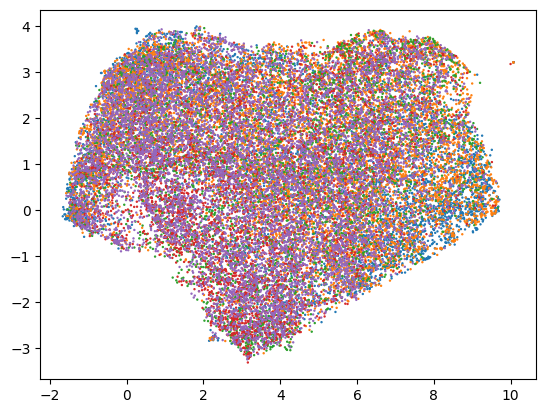

In [30]:
fig, sub = plt.subplots()
sub.scatter(
        um[:, 0],
        um[:, 1],
        marker='o', 
        s=(72./fig.dpi)**2,
        c=[sns.color_palette()[x] for x in labels]
    )

In [39]:
pred = model(X)
(F.softmax(pred, dim=1).argmax(dim=1) == y).sum() / y.shape[0]

tensor(0.5427)